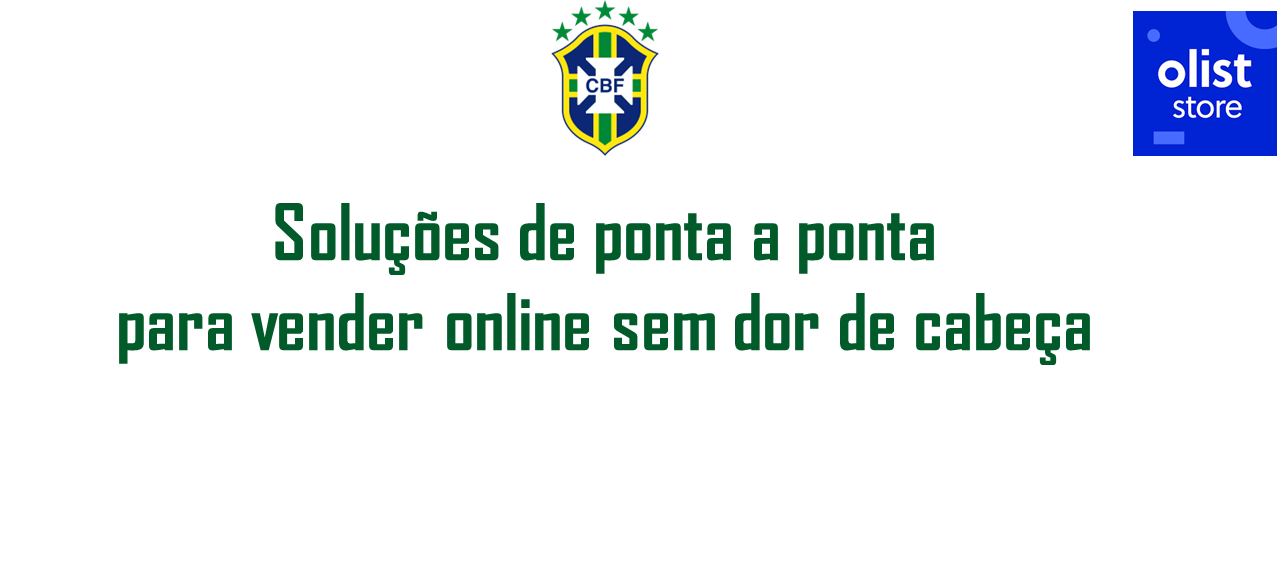

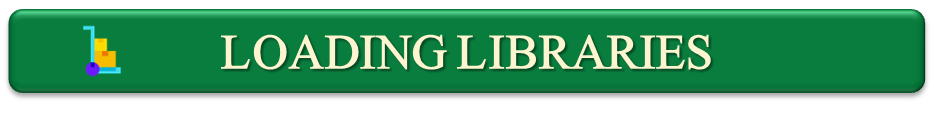

In [1]:
%load_ext pycodestyle_magic 
%pycodestyle_on 

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import scipy as sp
from pandas.tseries.offsets import MonthEnd
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from yellowbrick.features import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.cluster import adjusted_rand_score

 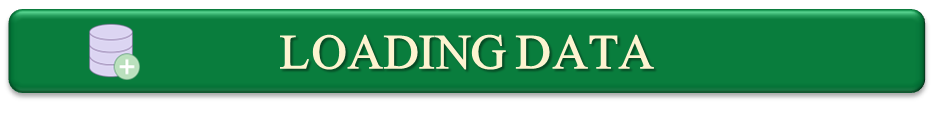

In [34]:
df = pd.read_csv('C:/Users/td/Documents/3. FORMATIONS/\
2 - OPENCLASSROOMS/Data Science/5. Projet 5/\
0. Data/customer_clusters.csv')

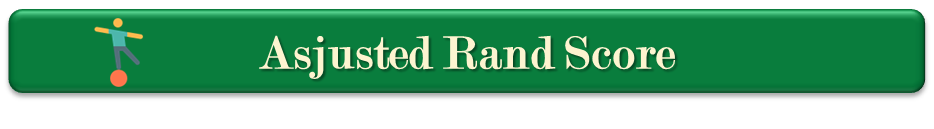

In [35]:
df.dtypes

customer_unique_id           object
order_id                     object
order_purchase_timestamp     object
review_score                float64
payment_value               float64
dtype: object

In [36]:
# Calculate each period

df['order_purchase_timestamp'] = pd.to_datetime((
    df['order_purchase_timestamp'])).dt.date

df['end_of_month'] = (df['order_purchase_timestamp']+MonthEnd())

In [37]:
list_of_deadline = np.unique(df['end_of_month'].dt.date)

In [38]:
# Inital dataframe

df_initial = df[df['order_purchase_timestamp'] <= list_of_deadline[2]]

In [39]:
# Deadline : End of month for each period

deadline = list_of_deadline[2]

# Initial dataframe : first clustering
df_prev = (df
           .groupby(['customer_unique_id'])
           .agg({
               'order_purchase_timestamp': lambda x: (deadline-x.max()).days,
               'order_id': 'count',
               'payment_value': sum,
               'review_score': 'mean'
           })
           .rename(columns={
               'order_purchase_timestamp': 'Recency',
               'order_id': 'Frequency',
               'payment_value': 'Monetary'
           })
           .reset_index())

In [40]:
# Pipeline

preprocessor = PowerTransformer(standardize=True)

model = KMeans(n_clusters=5)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)])

In [41]:
# First clustering

pipe.fit(df_prev.iloc[:, 1:])

Pipeline(steps=[('preprocessor', PowerTransformer()),
                ('model', KMeans(n_clusters=5))])

In [43]:
ari_score = []

for deadline in list_of_deadline[3:]:
    # Deadline
    df = df[df['order_purchase_timestamp'] <= deadline]
    # RFM
    df_rfm = (df
              .groupby(['customer_unique_id'])
              .agg({'order_purchase_timestamp':
                    lambda x: (deadline-x.max()).days,
                    'order_id': 'count',
                    'payment_value': sum,
                    'review_score': 'mean'})
              .rename(columns={
                  'order_purchase_timestamp': 'Recency',
                  'order_id': 'Frequency',
                  'payment_value': 'Monetary'})
              .reset_index())
    # Cluster with previous model
    pipe.predict(df_rfm.iloc[:, 1:])
    cluster_1 = pipe['model'].labels_
    # Cluster with the new model
    pipe.fit(df_rfm.iloc[:, 1:])
    cluster_2 = pipe['model'].labels_
    ari_score.append(adjusted_rand_score(cluster_1, cluster_2))

Text(0, 0.5, 'ARI Score')

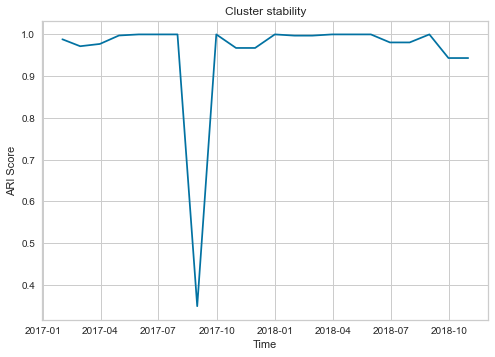

In [44]:
plt.plot(list_of_deadline[3:], ari_score)
plt.title('Cluster stability')
plt.xlabel('Time')
plt.ylabel('ARI Score')

In [45]:
list_of_deadline[9]

datetime.date(2017, 7, 31)

In [46]:
sept_deadline = list_of_deadline[9]
oct_deadline = list_of_deadline[10]

df_juil = (df
           .groupby(['customer_unique_id'])
           .agg({'order_purchase_timestamp':
                 lambda x: (sept_deadline-x.max()).days,
                 'order_id': 'count',
                 'payment_value': sum,
                 'review_score': 'mean'})
           .rename(columns={
               'order_purchase_timestamp': 'Recency',
               'order_id': 'Frequency',
               'payment_value': 'Monetary'})
           .reset_index())

df_aout = (df
           .groupby(['customer_unique_id'])
           .agg({'order_purchase_timestamp':
                 lambda x: (oct_deadline-x.max()).days,
                 'order_id': 'count',
                 'payment_value': sum,
                 'review_score': 'mean'})
           .rename(columns={
                 'order_purchase_timestamp': 'Recency',
                 'order_id': 'Frequency',
                 'payment_value': 'Monetary'})
           .reset_index())

pipe.fit(df_juil.iloc[:, 1:])
pipe.predict(df_aout.iloc[:, 1:])
cluster_pred = pipe['model'].labels_
pipe.fit(df_aout.iloc[:, 1:])
cluster_fit = pipe['model'].labels_

adjusted_rand_score(cluster_fit, cluster_pred)

0.3487278639368195

In [47]:
dict_cluster = {
    'Cluster_pred': cluster_pred,
    'Cluster_fit': cluster_fit
}

In [49]:
df_cluster = pd.concat([df_aout, pd.DataFrame(dict_cluster)], axis=1)

In [50]:
(df_cluster
 .groupby(['Cluster_pred'])
 .agg({
     'Recency': ['mean', 'median'],
     'Frequency': ['mean', 'median'],
     'Monetary': ['mean', 'median'],
     'review_score': ['mean',  'median'],
     'customer_unique_id': 'count'})
 .rename(columns={'customer_unique_id': 'number of customer'})
 .reset_index()
 .sort_values([('number of customer',  'count')], ascending=False))

Cluster_pred     Recency        Frequency           Monetary          \
                      mean median      mean median        mean  median   
1            1  219.687296    218  1.068404      1  285.184919  190.28   
0            0  220.830882    219  1.036765      1   55.740478   54.51   
4            4  328.383085    329  1.009950      1  184.975572  108.84   
2            2  220.147727    218  1.028409      1  195.622159  136.55   
3            3  329.347458    329  1.008475      1  179.681102  115.69   

  review_score        number of customer  
          mean median              count  
1     4.761401    5.0                307  
0     4.691176    5.0                272  
4     4.756219    5.0                201  
2     1.806818    1.0                176  
3     1.453390    1.0                118

In [51]:
(df_cluster
 .groupby(['Cluster_fit'])
 .agg({
     'Recency': ['mean', 'median'],
     'Frequency': ['mean', 'median'],
     'Monetary': ['mean', 'median'],
     'review_score': ['mean',  'median'],
     'customer_unique_id': 'count'})
 .rename(columns={'customer_unique_id': 'number of customer'})
 .reset_index()
 .sort_values([('number of customer',  'count')], ascending=False))

Cluster_fit     Recency        Frequency           Monetary           \
                     mean median      mean median        mean   median   
3           3  249.531722    222  1.045317      1  121.652477  116.170   
0           0  246.868852    223  1.028689      1   46.447459   47.020   
1           1  248.479592    221  1.056122      1  449.190000  348.165   
4           4  264.676301    228  1.028902      1  276.208902  192.190   
2           2  260.015385    225  1.007692      1   62.304692   63.555   

  review_score        number of customer  
          mean median              count  
3     4.730363    5.0                331  
0     4.758197    5.0                244  
1     4.806122    5.0                196  
4     1.575145    1.0                173  
2     1.861538    1.0                130

<AxesSubplot:ylabel='Cluster_fit'>

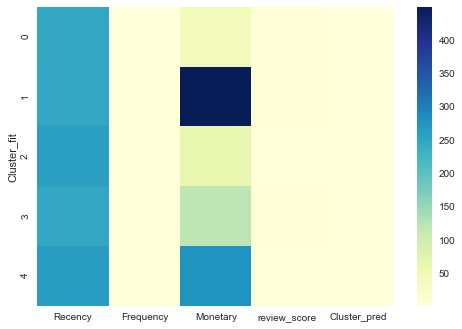

In [52]:
sns.heatmap((df_cluster.groupby(by='Cluster_fit')
            .agg('mean')),
            cmap='YlGnBu')

<AxesSubplot:ylabel='Cluster_pred'>

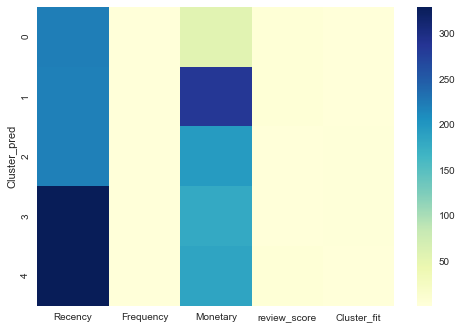

In [53]:
sns.heatmap((df_cluster.groupby(by='Cluster_pred')
            .agg('mean')),
            cmap='YlGnBu')

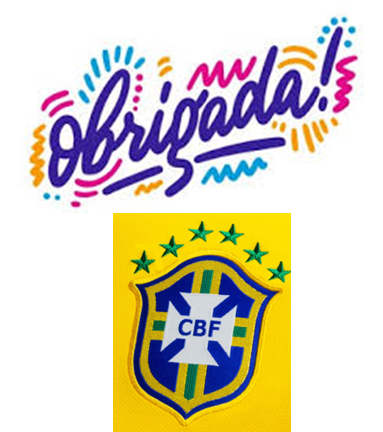